<a href="https://colab.research.google.com/github/nickfj94/Caso_de_estudio_marketing/blob/main/Copia_de_anal%C3%ADtica_marketing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#***Caso de estudio marketing***

*   Laura Rojas Urzola 
*   Nicolas Flórez Jiménez
*   Cristhian Guzmán Peña
---
#***Problema de negocio***
La plataforma online desea mejorar la fidelización de sus clientes, mediante un sistema de recomendación para que sus usuarios tengan una mejor experiencia

#***Problema de Analítico***
Crear un modelo de recomendaciones de películas a los clientes de una plataforma online




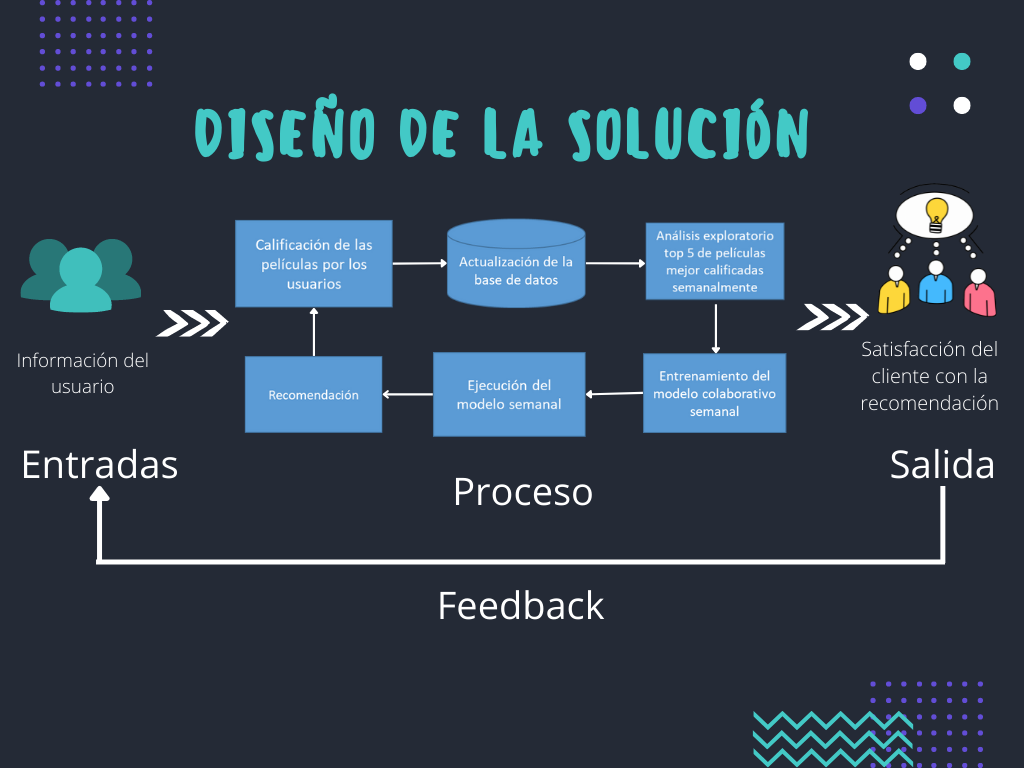

Para la solución se propone iniciar con una recolección de información de los usuarios más amplia de lo que se tiene hasta el momento, para poder realizar mejoras futuras según la retroalimentación que va obtenido el sistema; este tipo de nueva información seria relacionado con los usuarios, por ejemplo, la edad, la preferencia con los géneros de las películas, horas en las que prefiere ver películas, sus películas preferidas entre otras. Teniendo la información anterior se procede realizar una actualización de la base de datos y presentar el top 5 de las películas mejor calificadas. Posteriormente se ejecuta los modelos de recomendación para los usuarios semanalmente y se hace un seguimiento de la satisfacción de las recomendaciones brindadas por el modelo para finalmente lograr una retroalimentación mensual del funcionamiento del modelo.

#Instalación de librerias y carga de datos

In [ ]:
!pip install scikit-surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
## Librerías
from datetime import datetime
import pandas as pd
import numpy as np
import sqlite3 as sql
from matplotlib.pyplot import figure
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import sklearn
from surprise import Reader, Dataset
from surprise.model_selection import cross_validate, GridSearchCV
from surprise import KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline, SVD
from surprise.model_selection import train_test_split
import plotly.graph_objs as go ### para gráficos
from ipywidgets import interact ## para análisis interactivo
from sklearn.preprocessing import MinMaxScaler
from sklearn import neighbors
import plotly.express as px

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
conn= sql.connect("/content/drive/MyDrive/Analitica 3/db_movies")

df_movies=pd.read_sql("select * from movies", conn)

df_users = pd.read_sql("select *,datetime(timestamp,'unixepoch') as date from ratings", conn)

df_movies
df_users

,userId,movieId,rating,timestamp,date
0,1,1,4.0,964982703,2000-07-30 18:45:03
1,1,3,4.0,964981247,2000-07-30 18:20:47
2,1,6,4.0,964982224,2000-07-30 18:37:04
3,1,47,5.0,964983815,2000-07-30 19:03:35
4,1,50,5.0,964982931,2000-07-30 18:48:51
...,...,...,...,...,...
100831,610,166534,4.0,1493848402,2017-05-03 21:53:22
100832,610,168248,5.0,1493850091,2017-05-03 22:21:31
100833,610,168250,5.0,1494273047,2017-05-08 19:50:47
100834,610,168252,5.0,1493846352,2017-05-03 21:19:12


#Revisión de los datos

In [ ]:
#Conteo de usuarios y películas registradas 
print('Cantidad de usuarios',df_users['userId'].unique().shape[0])
print('Cantidad de películas',df_movies['movieId'].unique().shape[0])

Cantidad de usuarios 610
Cantidad de películas 9742


In [ ]:
#Información dataset de usuarios
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
 4   date       100836 non-null  object 
dtypes: float64(1), int64(3), object(1)
memory usage: 3.8+ MB


Se evidencia que no hay valores nulos

In [ ]:
#Información dataset de películas
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


Se evidencia que no hay valores nulos

In [ ]:
#cambiar la separación del género
#Se quita la separación por símbolo "|" y se convierten en listas la columna de géneros

df_movies['genres'] = df_movies.genres.str.split('|')
df_movies['genres']

0       [Adventure, Animation, Children, Comedy, Fantasy]
1                          [Adventure, Children, Fantasy]
2                                       [Comedy, Romance]
3                                [Comedy, Drama, Romance]
4                                                [Comedy]
                              ...                        
9737                 [Action, Animation, Comedy, Fantasy]
9738                         [Animation, Comedy, Fantasy]
9739                                              [Drama]
9740                                  [Action, Animation]
9741                                             [Comedy]
Name: genres, Length: 9742, dtype: object

In [ ]:
#Se cambia el formato de la columna "date" a formato fecha
df_users['date']= pd.to_datetime(df_users['date']) 

In [ ]:
#Se elimina la columna "timestamp"
df_users.drop(['timestamp'], axis=1,inplace=True)

In [ ]:
#Separar género en columnas
#Para cada fila del marco de datos, iterar la lista de géneros y colocar un 1 en la columna que corresponda
for index, row in df_movies.iterrows():
    for genre in row['genres']:
        df_movies.at[index, genre] = 1


#Completar los valores NaN con 0 para mostrar que una película no tiene el género de la columna
df_movies = df_movies.fillna(0)
df_movies.head()

,movieId,title,genres,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,...,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed)
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,Father of the Bride Part II (1995),[Comedy],0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#Eliminar la columna género
df_movies.drop(['genres'], axis=1,inplace=True)
df_movies

,movieId,title,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,...,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed)
0,1,Toy Story (1995),1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,Jumanji (1995),1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,Grumpier Old Men (1995),0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,Waiting to Exhale (1995),0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,Father of the Bride Part II (1995),0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9738,193583,No Game No Life: Zero (2017),0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9739,193585,Flint (2017),0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9740,193587,Bungo Stray Dogs: Dead Apple (2018),0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#creamos una columna nueva que se llamará year que solo
#contendrá el año de estreno de las películas que se encuentra en el titulo
df_movies['year'] = df_movies.title.str.extract('(\(\d\d\d\d\))',expand=False)
df_movies['year']

0       (1995)
1       (1995)
2       (1995)
3       (1995)
4       (1995)
         ...  
9737    (2017)
9738    (2017)
9739    (2017)
9740    (2018)
9741    (1991)
Name: year, Length: 9742, dtype: object

In [ ]:
#Quitando los paréntesis a los datos de la columna year
df_movies['year'] = df_movies.year.str.extract('(\d\d\d\d)',expand=False)
df_movies['year']

0       1995
1       1995
2       1995
3       1995
4       1995
        ... 
9737    2017
9738    2017
9739    2017
9740    2018
9741    1991
Name: year, Length: 9742, dtype: object

In [ ]:
#Eliminar los años de la columna "título" y el espacio
df_movies['title'] = df_movies.title.str.replace(' (\(\d\d\d\d\))', '')
df_movies['title']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

The default value of regex will change from True to False in a future version.



0                                Toy Story
1                                  Jumanji
2                         Grumpier Old Men
3                        Waiting to Exhale
4              Father of the Bride Part II
                       ...                
9737    Black Butler: Book of the Atlantic
9738                 No Game No Life: Zero
9739                                 Flint
9740          Bungo Stray Dogs: Dead Apple
9741          Andrew Dice Clay: Dice Rules
Name: title, Length: 9742, dtype: object

En la revisión de los datos se evidencia que tenemos una base con 610 usuarios y 9.742 películas sin datos nulos, se hace un tratamiento a los datos, donde se elimina la columna timestamp, ya que es una marca de tiempo y no será necesaria, por lo que podemos prescindir de ella para ahorrar espacio de memoria, además sacamos el año de la columna title y la guardamos en una nueva columna llamada year, por último se convirtió la lista de géneros en un vector donde cada columna corresponde a un valor de la característica mencionada. Esta codificación se necesita para alimentar datos categóricos. En este caso, guardamos cada género distinto en columnas que tienen 1 ó 0. 1 quiere decir que una película tiene género y 0 que no lo tiene.

#ANÁLISIS EXPLORATORIO


In [ ]:
print('Información películas')
print(df_movies.info())
print('')
print('-------------------------')
print('Información usuarios')
print(df_users.info())
print('')
print('-------------------------')
print('Datos películas')
print(df_movies)
print('')
print('-------------------------')
print('Datos usuarios')
print(df_users)

Información películas
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   movieId             9742 non-null   int64  
 1   title               9742 non-null   object 
 2   Adventure           9742 non-null   float64
 3   Animation           9742 non-null   float64
 4   Children            9742 non-null   float64
 5   Comedy              9742 non-null   float64
 6   Fantasy             9742 non-null   float64
 7   Romance             9742 non-null   float64
 8   Drama               9742 non-null   float64
 9   Action              9742 non-null   float64
 10  Crime               9742 non-null   float64
 11  Thriller            9742 non-null   float64
 12  Horror              9742 non-null   float64
 13  Mystery             9742 non-null   float64
 14  Sci-Fi              9742 non-null   float64
 15  War                 9742 non-null

In [ ]:
#Conteo de películas por año
pd.crosstab(index=df_movies['year'], columns=' count ')

col_0,count
year,
1902,1
1903,1
1908,1
1915,1
1916,4
...,...
2014,278
2015,274
2016,218


In [ ]:
# crear dataset
base = df_movies.groupby(['year'])[['movieId']].count().reset_index()

# crear gráfica
fig = px.bar(base, x = 'movieId', y='year', color ='movieId' , barmode = 'group', title= '<b>Cantidad de peliculas por año<b>')

# agregar detalles a la gráfica
fig.update_layout(
    xaxis_title = 'movieId',
    yaxis_title = 'year', title_x = 0.5)

fig.show()

Las bases de las películas van hasta el 2018, el año con más registro de películas es el 2002 con 311 películas, además se puede observar que a partir del 1931 empiezan a aumentar las producciones de películas

Text(0.5, 1.0, 'Conteo calificaciones por año')

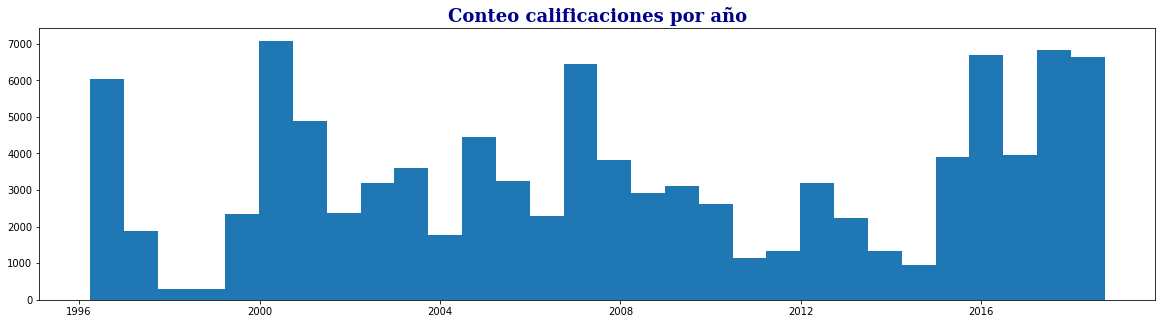

In [ ]:
# Histograma de conteo por año en que se calificó las películas
plt.hist(df_users.date,bins=30)
plt.title("Conteo calificaciones por año", 
          fontdict={'family': 'serif', 
                    'color' : 'darkblue',
                    'weight': 'bold',
                    'size': 18})

Las personas empezaron a llevar registro de la calificiación de las películas desde 1996.

-Supuesto
La empresa entre los años 2000, 2006 y 2016 aproximadamente tuvo un aumento en calificaciones, esto se pudo dar por campañas de promoción de la plataforma


In [ ]:
#Conteo de calificación 
pd.crosstab(index=df_users['rating'], columns=' count ')

col_0,count
rating,
0.5,1370
1.0,2811
1.5,1791
2.0,7551
2.5,5550
3.0,20047
3.5,13136
4.0,26818
4.5,8551


(array([ 1370.,  2811.,  1791.,  7551.,  5550., 20047., 13136., 26818.,
         8551., 13211.]),
 array([0.5 , 0.95, 1.4 , 1.85, 2.3 , 2.75, 3.2 , 3.65, 4.1 , 4.55, 5.  ]),
 <a list of 10 Patch objects>)

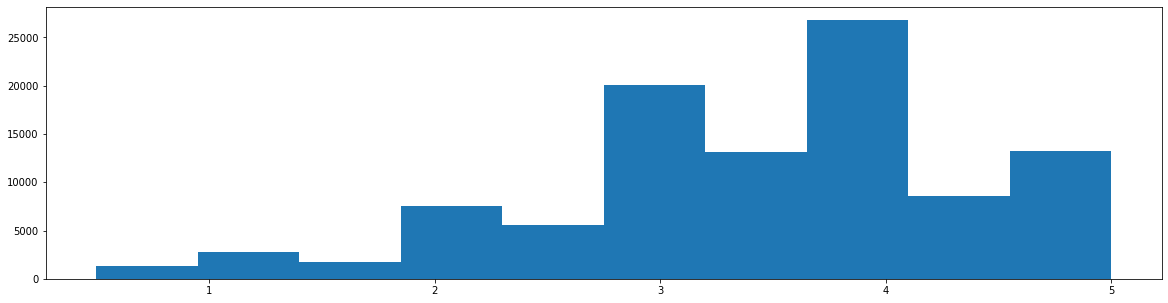

In [ ]:
#Histograma del conteo de clasificación
plt.hist(df_users.rating,bins=10)

La escala de calificación va de 0,5 a 5,0 donde la calificación más usada ha sido de 4,0 y la menos usada es de 0,5

In [ ]:
cr=pd.crosstab(index=df_users['rating'], columns=' count ').reset_index()
cr.dtypes

col_0
rating     float64
 count       int64
dtype: object

In [ ]:
# Conteo de cuantas veces cada usuario ha calificado en la plataforma
rating_users=df_users.groupby('userId')[['rating']].count().sort_values('rating',ascending=False).reset_index()
rating_users

,userId,rating
0,414,2698
1,599,2478
2,474,2108
3,448,1864
4,274,1346
...,...,...
605,442,20
606,569,20
607,320,20
608,576,20


In [ ]:
#Grafico usuarios y rating
data  = go.Scatter(x = rating_users.index, y= rating_users.rating)
Layout= go.Layout(title="Ratings Por los usuarios",xaxis={'title':'Conteo usuario'}, yaxis={'title':'Ratings'})
go.Figure(data, Layout)  

Se evidencia que apenas 11 personas han visto más de mil películas

Además, la mitad de los usuarios han visto menos de cien películas

In [ ]:
# Matriz peliculas ID y rating, es decir, la cantidad de veces que le han dado cierta calificación a cada película
pd.crosstab(index=df_users['rating'], columns=df_users['movieId'], margins=True)

movieId,1,2,3,4,5,6,7,8,9,10,...,193567,193571,193573,193579,193581,193583,193585,193587,193609,All
rating,,,,,,,,,,,,,,,,,,,,,
0.5,1,1,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1370
1.0,0,1,3,1,0,1,5,1,0,2,...,0,0,0,0,0,0,0,0,0,2811
1.5,1,2,1,1,2,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1791
2.0,6,5,2,1,6,2,3,1,2,9,...,0,0,0,0,0,0,0,0,0,7551
2.5,8,12,2,0,2,0,2,0,1,2,...,0,0,0,0,0,0,0,0,0,5550
3.0,34,28,20,4,25,23,22,5,8,43,...,1,0,0,0,0,0,0,0,0,20047
3.5,18,11,5,0,1,7,2,0,0,16,...,0,0,0,1,0,1,1,1,0,13136
4.0,82,36,12,0,8,37,16,0,2,39,...,0,1,1,0,1,0,0,0,1,26818
4.5,18,7,0,0,1,8,2,0,0,10,...,0,0,0,0,0,0,0,0,0,8551


In [ ]:
# Matriz userID y rating, es decir, la cantidad de veces que le han dado cierta calificación a cada usuario
pd.crosstab(index=df_users['rating'], columns=df_users['userId'], margins=True)

userId,1,2,3,4,5,6,7,8,9,10,...,602,603,604,605,606,607,608,609,610,All
rating,,,,,,,,,,,,,,,,,,,,,
0.5,0,0,20,0,0,0,6,0,0,9,...,0,0,0,0,4,0,33,0,3,1370
1.0,1,0,0,23,1,7,12,1,6,6,...,5,85,1,8,6,3,29,0,13,2811
1.5,0,0,0,0,0,0,12,0,0,1,...,0,0,0,0,13,0,30,0,11,1791
2.0,5,1,1,26,3,13,11,3,6,5,...,12,84,3,18,22,10,69,0,42,7551
2.5,0,1,0,0,0,0,7,0,0,9,...,0,0,0,15,79,0,95,0,74,5550
3.0,26,4,1,39,17,152,16,21,12,30,...,64,211,52,84,137,63,169,27,230,20047
3.5,0,4,1,0,0,0,18,0,0,30,...,0,0,0,44,241,0,126,0,315,13136
4.0,76,9,1,64,13,102,28,12,14,25,...,33,393,35,35,441,59,162,10,286,26818
4.5,0,4,5,0,0,0,29,0,0,11,...,0,0,0,6,139,0,95,0,148,8551


Las calificaciones reflejan la cantidad de vistas que ha tenido una pelicula

In [ ]:
# Unión bases de datos
df = df_users.merge(df_movies, on = 'movieId', how = 'left')
df

,userId,movieId,rating,date,title,Adventure,Animation,Children,Comedy,Fantasy,...,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed),year
0,1,1,4.0,2000-07-30 18:45:03,Toy Story,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1995
1,1,3,4.0,2000-07-30 18:20:47,Grumpier Old Men,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1995
2,1,6,4.0,2000-07-30 18:37:04,Heat,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1995
3,1,47,5.0,2000-07-30 19:03:35,Seven (a.k.a. Se7en),0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1995
4,1,50,5.0,2000-07-30 18:48:51,"Usual Suspects, The",0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100831,610,166534,4.0,2017-05-03 21:53:22,Split,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017
100832,610,168248,5.0,2017-05-03 22:21:31,John Wick: Chapter Two,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017
100833,610,168250,5.0,2017-05-08 19:50:47,Get Out,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017
100834,610,168252,5.0,2017-05-03 21:19:12,Logan,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017


In [ ]:
# Las 5 películas más veces calificadas
top5 = df.groupby(['movieId','title','year'])['rating'].count().sort_values(ascending=False).head()
top5

movieId  title                      year
356      Forrest Gump               1994    329
318      Shawshank Redemption, The  1994    317
296      Pulp Fiction               1994    307
593      Silence of the Lambs, The  1991    279
2571     Matrix, The                1999    278
Name: rating, dtype: int64

Las películas más calificadas son de los años 90, esto también lo tomamos como posiblemente las películas más vistas por los usuarios

In [ ]:
# Las 5 películas menos veces calificadas
df.groupby(['movieId','title','year'])['rating'].count().sort_values(ascending=False).tail()

movieId  title                          year
27816    Saints and Soldiers            2003    1
27826    Touch of Pink                  2004    1
27829    Slasher                        2004    1
27830    Bobby Jones, Stroke of Genius  2004    1
193609   Andrew Dice Clay: Dice Rules   1991    1
Name: rating, dtype: int64

Podemos suponer que la fecha de la película puede no ser tan determinante para calificarla más que otra

In [ ]:
# Separación de la fecha de calificación por columna, es decir, una columna para el año, una para el mes y otra para el día
df['day_rating'] = pd.to_datetime(df_users['date']).dt.day
df['month_rating'] = pd.to_datetime(df_users['date']).dt.month
df['year_rating'] = pd.to_datetime(df_users['date']).dt.year
df.drop(['date'], axis=1,inplace=True)

In [ ]:
# Cantidad de calificaciones por mes del año
month_rating=df.groupby(['month_rating'])['rating'].count().sort_values(ascending=False).reset_index()
month_rating

,month_rating,rating
0,5,10883
1,11,9676
2,8,9074
3,3,8880
4,6,8825
5,1,8684
6,9,8510
7,4,7727
8,2,7635
9,10,7148


In [ ]:
data  = go.Bar( x=month_rating.month_rating,y=month_rating.rating, text=str(month_rating.rating), textposition="outside")
Layout=go.Layout(title="Conteo de rating por mes",xaxis={'title':'Mes'},yaxis={'title':'Conteo'})
go.Figure(data,Layout)

El mes donde más se han calificado películas es mayo con una gran diferencia respecto a los otros meses y el de menor calificaciones es el mes de julio, suponemos que esto puede ser posible porque al parecer hay vacaciones escolares en Estados Unidos entre mayo y junio, retomando sus clases en julio que es el mes donde menos calificaciones existe.

In [ ]:
# Cantidad de calificaciones por año de la pelicula
df.groupby(['year'])['rating'].count().sort_values(ascending=False)

year
1995    6144
1994    5296
1999    4536
1996    4509
2000    4268
        ... 
1903       2
1919       1
1917       1
1915       1
1908       1
Name: rating, Length: 106, dtype: int64

Las películas que más veces se han calificado son las estrenadas en la década de los 90’s

In [ ]:
rating_movie=df.groupby('movieId')[['rating']].count().sort_values('rating',ascending=False).reset_index()
rating_movie

,movieId,rating
0,356,329
1,318,317
2,296,307
3,593,279
4,2571,278
...,...,...
9719,4093,1
9720,4089,1
9721,58351,1
9722,4083,1


In [ ]:
#Grafico peliculas y rating
data  = go.Scatter(x = rating_movie.index, y= rating_movie.rating)
Layout= go.Layout(title="Ratings recibido por pelicula",xaxis={'title':'Conteo Peliculas'}, yaxis={'title':'Ratings'})
go.Figure(data, Layout)    

La mayoría de las películas han sido calificadas menos de 10 veces

In [ ]:
df.isnull().sum()

userId                 0
movieId                0
rating                 0
title                  0
Adventure              0
Animation              0
Children               0
Comedy                 0
Fantasy                0
Romance                0
Drama                  0
Action                 0
Crime                  0
Thriller               0
Horror                 0
Mystery                0
Sci-Fi                 0
War                    0
Musical                0
Documentary            0
IMAX                   0
Western                0
Film-Noir              0
(no genres listed)     0
year                  18
day_rating             0
month_rating           0
year_rating            0
dtype: int64

18 peliculas no tienen el año en que se elaboraron


### ------------------ALGORITMOS----------------
###Filtro colaborativo
###basado en usuario
###metodo: distancia por coseno de los vectores

In [ ]:
#matriz en la que cruzamos todos los usuarios con todos las películas
matriz = pd.pivot_table(df_users, values='rating', index='userId', columns='movieId').fillna(0)
matriz

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
607,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
608,2.5,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#porcentaje de sparcity
ratings = matriz.values
sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0] * ratings.shape[1])
sparsity *= 100
print('Sparsity: {:4.2f}%'.format(sparsity))

Sparsity: 1.70%


In [ ]:
ratings

array([[4. , 0. , 4. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [2.5, 2. , 2. , ..., 0. , 0. , 0. ],
       [3. , 0. , 0. , ..., 0. , 0. , 0. ],
       [5. , 0. , 0. , ..., 0. , 0. , 0. ]])

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
#conjunto de entrenamiento y de prueba
ratings_train, ratings_test = train_test_split(ratings, test_size = 0.33, random_state=42)
print(ratings_train.shape)
print(ratings_test.shape)

(408, 9724)
(202, 9724)


In [ ]:
#matriz de similitud entre usuarios
sim_matrix = 1 - sklearn.metrics.pairwise.cosine_distances(ratings)
print(sim_matrix.shape)

(610, 610)


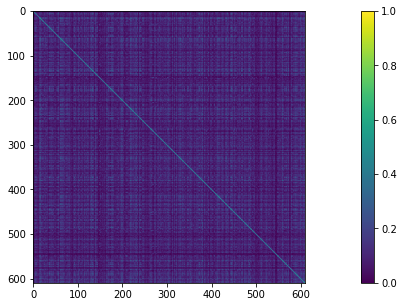

In [ ]:
#ver similud graficamente
plt.imshow(sim_matrix);
plt.colorbar()
plt.show()


Esta matriz representa la similitud entre los usuarios y se evidencia que no hay un puntaje de similitud, esto se debe a que los usuarios no han calificado muchas películas, y el porcentaje de sparcity nos lo confirma al dar un valor muy pequeño

In [ ]:
#separar las filas y columnas de train y test
sim_matrix_train = sim_matrix[0:408,0:408]
sim_matrix_test = sim_matrix[408:610,408:610]
users_predictions = sim_matrix_train.dot(ratings_train) / np.array([np.abs(sim_matrix_train).sum(axis=1)]).T


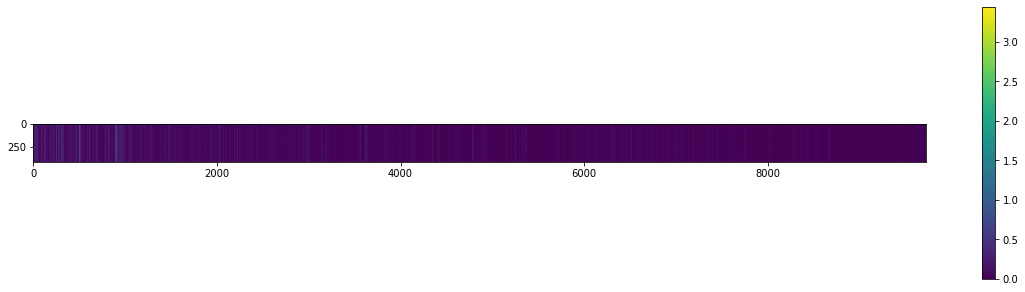

In [ ]:
#ver recomendaciones entre todas las peliculas y usuarios graficamente
plt.rcParams['figure.figsize'] = (20.0, 5.0)
plt.imshow(users_predictions);
plt.colorbar()
plt.show()

En esta grafica se muestran las recomendaciones para los usuarios

In [ ]:
#ejemplo de prediccón de usuario
usuario_ver = 0 #indice
user0=users_predictions.argsort()[usuario_ver]

In [ ]:
# ver los 5 recomendados con mayor puntaje en la predic para este usuario
puntajes = []
dfprueba = pd.DataFrame()
for i, aRepo in enumerate(user0[-5:]):
    selRepo = df_movies[df_movies['movieId']==(aRepo+1)]
    resultado = selRepo[['title','movieId']]
    puntajes.append(users_predictions[usuario_ver][aRepo])
    dfprueba = pd.concat([resultado, dfprueba], axis=0)

dfprueba['Puntaje'] = puntajes	
dfprueba

,title,movieId,Puntaje
240,Miami Rhapsody,278,1.723909
274,"Specialist, The",315,1.959642
222,"Kid in King Arthur's Court, A",258,2.099166
446,"Program, The",511,2.144418
1417,"Best Years of Our Lives, The",1939,2.246112


In [ ]:
#evaluación del error
def get_mse(preds, actuals):
    if preds.shape[1] != actuals.shape[1]:
        actuals = actuals.T
    preds = preds[actuals.nonzero()].flatten()
    actuals = actuals[actuals.nonzero()].flatten()
    return mean_squared_error(preds, actuals)



In [ ]:
print("Entrenamiento",get_mse(users_predictions, ratings_train))

# Realizo las predicciones para el test set
users_predictions_test = sim_matrix.dot(ratings) / np.array([np.abs(sim_matrix).sum(axis=1)]).T
users_predictions_test = users_predictions_test[408:610,:]
print("Test",get_mse(users_predictions_test, ratings_test))


Entrenamiento 10.38770443703889
Test 10.33103307647139


Vemos que para el conjunto de train y test el MAE es bastante cercano. Un indicador de que no tiene buenas predicciones sería si el MAE en test fuera 2 veces más (o la mitad) del valor del de train.

### ALGORITMOS
#filtro colaborativo
#basado en contenido
#Metodo ponderacion de los generos


In [ ]:
usuario = df.loc[:,'userId']==1
df_usuario = df.loc[usuario]
df_usuario
df_usuario.drop(['userId','month_rating','year_rating','day_rating'], axis=1,inplace=True)
df_usuario.info()
df_usuario['year'].unique()
df_usuario['year']=df_usuario['year'].astype(int)
df_usuario = df_usuario.convert_dtypes()
df_movies

df_usuario = df_usuario.reset_index(drop=True)
tabla_usuario = df_usuario.drop(['movieId','rating','title','year'],axis = 1)
tabla_usuario

df_usuario['rating']

<class 'pandas.core.frame.DataFrame'>
Int64Index: 232 entries, 0 to 231
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   movieId             232 non-null    int64  
 1   rating              232 non-null    float64
 2   title               232 non-null    object 
 3   Adventure           232 non-null    float64
 4   Animation           232 non-null    float64
 5   Children            232 non-null    float64
 6   Comedy              232 non-null    float64
 7   Fantasy             232 non-null    float64
 8   Romance             232 non-null    float64
 9   Drama               232 non-null    float64
 10  Action              232 non-null    float64
 11  Crime               232 non-null    float64
 12  Thriller            232 non-null    float64
 13  Horror              232 non-null    float64
 14  Mystery             232 non-null    float64
 15  Sci-Fi              232 non-null    float64
 16  War     

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



0      4
1      4
2      4
3      5
4      5
      ..
227    4
228    5
229    4
230    4
231    5
Name: rating, Length: 232, dtype: Int64

In [ ]:
#Producto escalar entre la tabla usario y el dataframe usuario para obtener los pesos
perfil = tabla_usuario.transpose().dot(df_usuario['rating'])
#Perfil del usuario
perfil

Adventure             373
Animation             136
Children              191
Comedy                355
Fantasy               202
Romance               112
Drama                 308
Action                389
Crime                 196
Thriller              228
Horror                 59
Mystery                75
Sci-Fi                169
War                    99
Musical               103
Documentary             0
IMAX                    0
Western                30
Film-Noir               5
(no genres listed)      0
dtype: object

In [ ]:
#Ahora llevemos los géneros de cada película al marco de datos original
tabla_genero = df_movies.set_index(df_movies['movieId'])

In [ ]:
# Eliminemos información innecesaria
tabla_genero = tabla_genero.drop(['movieId','title','year'],axis = 1)
tabla_genero.head()

,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed)
movieId,,,,,,,,,,,,,,,,,,,,
1,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#Multiplicando los géneros por los pesos para luego calcular el peso promedio
df_recomendaciones = ((tabla_genero*perfil).sum(axis=1))/(perfil.sum())
df_recomendaciones.head()
df_recomendaciones = df_recomendaciones.sort_values(ascending =False)
df_recomendaciones = pd.DataFrame(df_recomendaciones)
df_recomendaciones.reset_index(inplace=True, drop=False)

df2 = df_recomendaciones.merge(df_movies, on = 'movieId', how = 'left')
df2 = df2.rename(columns={0:'puntaje'})
df2[['title','puntaje']].head()


,title,puntaje
0,Rubber,0.666007
1,Dragonheart 2: A New Beginning,0.612211
2,Aelita: The Queen of Mars (Aelita),0.587789
3,"Stunt Man, The",0.582508
4,Osmosis Jones,0.568977




**Recomendaciones basadas en similitud entre usuarios**


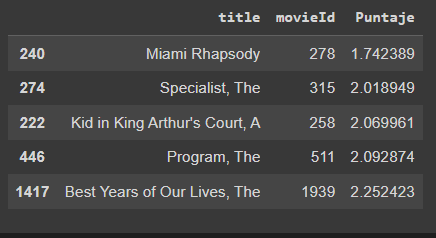


**Recomendaciones basadas en similitud entre contenidos**




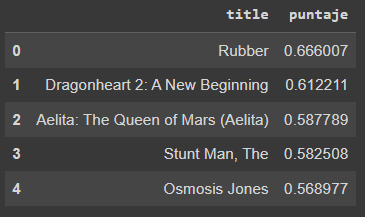



# Algoritmos clase

---
#####1. Sistema de recomendación filtro colaborativo basado en usuario #####
---

In [ ]:
#Datos nulos
df[df['year'].isnull()]

,userId,movieId,rating,title,Adventure,Animation,Children,Comedy,Fantasy,Romance,...,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed),year,day_rating,month_rating,year_rating
9147,62,176601,5.0,Black Mirror,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,NaN,8,5,2018
16886,105,147250,5.0,The Adventures of Sherlock Holmes and Doctor W...,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,NaN,13,5,2018
16913,105,171749,5.0,Death Note: Desu nôto (2006–2007),0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,NaN,13,5,2018
17879,111,171631,1.0,Maria Bamford: Old Baby,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,NaN,31,1,2018
17881,111,171891,3.5,Generation Iron 2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,NaN,31,1,2018
30039,209,140956,3.5,Ready Player One,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,23,4,2018
30090,210,40697,4.0,Babylon 5,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,25,5,2018
46593,305,140956,4.5,Ready Player One,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,31,7,2018
46711,306,149334,3.0,Nocturnal Animals,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,11,2,2018
49851,318,171495,5.0,Cosmos,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,NaN,24,1,2018


In [ ]:
# Eliminar datos nulos, porque al ser una cantidad pequeña no creemos que afecte el resultado final
df=df.dropna()
df.isnull().sum()

userId                0
movieId               0
rating                0
title                 0
Adventure             0
Animation             0
Children              0
Comedy                0
Fantasy               0
Romance               0
Drama                 0
Action                0
Crime                 0
Thriller              0
Horror                0
Mystery               0
Sci-Fi                0
War                   0
Musical               0
Documentary           0
IMAX                  0
Western               0
Film-Noir             0
(no genres listed)    0
year                  0
day_rating            0
month_rating          0
year_rating           0
dtype: int64

In [ ]:
#Datos duplicados
df.duplicated().sum() 

0

In [ ]:
# Se convierte el año a tipo entero
df['year']=df.year.astype('int')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
#Datos de rating
df['rating'].unique()

array([4. , 5. , 3. , 2. , 1. , 4.5, 3.5, 2.5, 0.5, 1.5])

In [ ]:
###### leer datos desde tabla de pandas
reader = Reader(rating_scale=(0.5, 5))

###las columnas deben estar en orden estándar: user item rating
data   = Dataset.load_from_df(df[['userId','movieId','rating']], reader)

models=[KNNBasic(),KNNWithMeans(),KNNWithZScore(),KNNBaseline()] 
results = {}

for model in models:
 
    CV_scores = cross_validate(model, data, measures=["MAE","RMSE"], cv=5, n_jobs=-1)  
    result = pd.DataFrame.from_dict(CV_scores).mean(axis=0).\
             rename({'test_mae':'MAE', 'test_rmse': 'RMSE'})
    results[str(model).split("algorithms.")[1].split("object ")[0]] = result


performance_df = pd.DataFrame.from_dict(results).T
performance_df.sort_values(by='RMSE')

,MAE,RMSE,fit_time,test_time
knns.KNNBaseline,0.669055,0.875217,0.249388,2.664291
knns.KNNWithZScore,0.679022,0.895380,0.233948,2.332568
knns.KNNWithMeans,0.685201,0.897169,0.170323,2.349838
knns.KNNBasic,0.726316,0.947699,0.170610,1.924279


Teniendo en cuenta el menor RMSE se sugiere escoger la medida de knns.KNNBaseline aunque todos los valores estan cercanos, pero por tiempo de ajuste y prueba es recomendado utilizar KNNWithMeans, ya que toma mucho menos tiempo que los demas. Viendo que el RMSE esta muy cercano entre todos la decision se toma por los tiempos por lo que se decide trabajar con KNNWithMeans

In [ ]:
#ajuste hiperparametros

param_grid = { 'sim_options' : {'name': ['msd','cosine'], \
                                'min_support': [5], \
                                'user_based': [False, True]}
             }

In [ ]:
gridsearchKNNWithMeans = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse'], \
                                      cv=2, n_jobs=-1)
           

In [ ]:
gridsearchKNNWithMeans.fit(data)



/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



In [ ]:
gridsearchKNNWithMeans.best_params["rmse"]

{'sim_options': {'min_support': 5, 'name': 'msd', 'user_based': True}}

In [ ]:
gridsearchKNNWithMeans.best_score["rmse"]

0.9241363637206645

Despues del ajuste de hiperparametros, se evidencia que es mejor trabajar con los parametros originales, dado que el RMSE aumento con los cambios

In [ ]:
trainset = data.build_full_trainset()
model = KNNBaseline()
model=model.fit(trainset)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


In [ ]:
predset = trainset.build_anti_testset() 
predictions = model.test(predset) ### función muy pesada
predictions_df = pd.DataFrame(predictions)

In [ ]:
predictions_df

,uid,iid,r_ui,est,details
0,1,318,3.501532,5.000000,"{'actual_k': 40, 'was_impossible': False}"
1,1,1704,3.501532,4.825179,"{'actual_k': 40, 'was_impossible': False}"
2,1,6874,3.501532,4.726457,"{'actual_k': 40, 'was_impossible': False}"
3,1,8798,3.501532,4.539018,"{'actual_k': 40, 'was_impossible': False}"
4,1,46970,3.501532,4.073510,"{'actual_k': 28, 'was_impossible': False}"
...,...,...,...,...,...
5822887,610,7377,3.501532,3.964672,"{'actual_k': 1, 'was_impossible': False}"
5822888,610,8667,3.501532,3.964672,"{'actual_k': 1, 'was_impossible': False}"
5822889,610,32302,3.501532,4.464672,"{'actual_k': 1, 'was_impossible': False}"
5822890,610,51903,3.501532,2.964672,"{'actual_k': 1, 'was_impossible': False}"


In [ ]:
def recomendaciones(user_id,n_recomend=10):
    
    predictions_userID = predictions_df[predictions_df['uid'] == user_id].\
                    sort_values(by="est", ascending = False).head(n_recomend)

    recomendados = predictions_userID[['iid','est']]
    recomendados.to_sql('reco',conn,if_exists="replace")
    
    recomendados=pd.read_sql('''select a.*, b.title 
                             from reco a left join movies b
                             on a.iid=b.movieId ''', conn)

    return(recomendados)

In [ ]:
predictions_df['uid'].unique()[:20] 

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])

In [ ]:
us1=recomendaciones(user_id=1,n_recomend=10)
us1

,index,iid,est,title
0,0,318,5.0,"Shawshank Redemption, The (1994)"
1,4441,2969,5.0,"Man and a Woman, A (Un homme et une femme) (1966)"
2,4792,100843,5.0,Oh Boy (A Coffee in Berlin) (2012)
3,4795,112454,5.0,Honey (Miele) (2013)
4,4796,133780,5.0,Güeros (2014)
5,4797,138396,5.0,There Will Come a Day (2013)
6,4798,152270,5.0,The Wait (2015)
7,889,3429,5.0,Creature Comforts (1989)
8,4801,179709,5.0,Wonder Wheel (2017)
9,4816,1836,5.0,"Last Days of Disco, The (1998)"


Se elige el modelo Kmeans por tener el menor tiempo de fit_time y presenta buenas predicciones de recomendación

#######################################################################
#### Sistema de recomendación basado en contenido KNN #################
#######################################################################

In [ ]:
#Datos nulos base de datos películas
df_movies.isnull().sum()

movieId                0
title                  0
Adventure              0
Animation              0
Children               0
Comedy                 0
Fantasy                0
Romance                0
Drama                  0
Action                 0
Crime                  0
Thriller               0
Horror                 0
Mystery                0
Sci-Fi                 0
War                    0
Musical                0
Documentary            0
IMAX                   0
Western                0
Film-Noir              0
(no genres listed)     0
year                  13
dtype: int64

In [ ]:
#Eliminar datos nulos
df_movies=df_movies.dropna()

In [ ]:
# escalar para que año esté en el mismo rango
sc=MinMaxScaler()
df_movies[["year_sc"]]=sc.fit_transform(df_movies[['year']])

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
# Se eliminan las columnas 'movieId','title' y 'year'
df_movies2=df_movies.drop(columns=['movieId','title','year'])
df_movies2

,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,...,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed),year_sc
0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.801724
1,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.801724
2,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.801724
3,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.801724
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.801724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.991379
9738,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.991379
9739,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.991379
9740,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000


In [ ]:
# entrenar modelo
model = neighbors.NearestNeighbors(n_neighbors=5, metric='cosine')
model.fit(df_movies2)
dist, idlist = model.kneighbors(df_movies2)

distancias=pd.DataFrame(dist)
id_list=pd.DataFrame(idlist)

In [ ]:
# Se realizan predicciones
def MovieRecommender(movie_name = list(df_movies['title'].value_counts().index)):
    movie_list_name = []
    movie_id = df_movies[df_movies['title'] == movie_name].index
    movie_id = movie_id[0]
    for newid in idlist[movie_id]:
        movie_list_name.append(df_movies.loc[newid].title)
    return movie_list_name

print(interact(MovieRecommender))

interactive(children=(Dropdown(description='movie_name', options=('Hamlet', 'Christmas Carol, A', 'Misérables,…

<function MovieRecommender at 0x7f0feab05a70>


---
##### Sistema de recomendación basado en contenido KNN #################
##### Con base en todo lo visto por el usuario #######################
---

In [ ]:
# Se crea una tabla con los ID de los usuarios
usuarios=pd.read_sql('select distinct (userId) as user_id from ratings',conn)
usuarios

,user_id
0,1
1,2
2,3
3,4
4,5
...,...
605,606
606,607
607,608
608,609


In [ ]:
def recomendar(user_id=list(usuarios['user_id'].value_counts().index)):
    
    ratings=pd.read_sql('select *from ratings where userId=:user',conn, params={'user':user_id})
    l_movie_r=ratings['movieId'].to_numpy()
    df_movies2[['movieId','title']]=df_movies[['movieId','title']]
    movie_r=df_movies2[df_movies2['movieId'].isin(l_movie_r)]
    movie_r=movie_r.drop(columns=['movieId','title'])
    movie_r["indice"]=1 
    centroide=movie_r.groupby("indice").mean()
    
    
    movie_nr=df_movies2[~df_movies2['movieId'].isin(l_movie_r)]
    movie_nr=movie_nr.drop(columns=['movieId','title'])
    model=neighbors.NearestNeighbors(n_neighbors=5, metric='cosine')
    model.fit(movie_nr)
    dist, idlist = model.kneighbors(centroide)
    
    ids=idlist[0]
    recomend_m=df_movies.loc[ids][['title','movieId']]
    vistos=df_movies[df_movies['movieId'].isin(l_movie_r)][['title','movieId']]
    
    return recomend_m

recomendar(1)

,title,movieId
6337,Flushed Away,48982
8364,"Zero Theorem, The",109187
3295,Africa: The Serengeti,4458
9155,The Lord's Lantern in Budapest,147936
7176,"Boondock Saints II: All Saints Day, The",72167


# Despligue

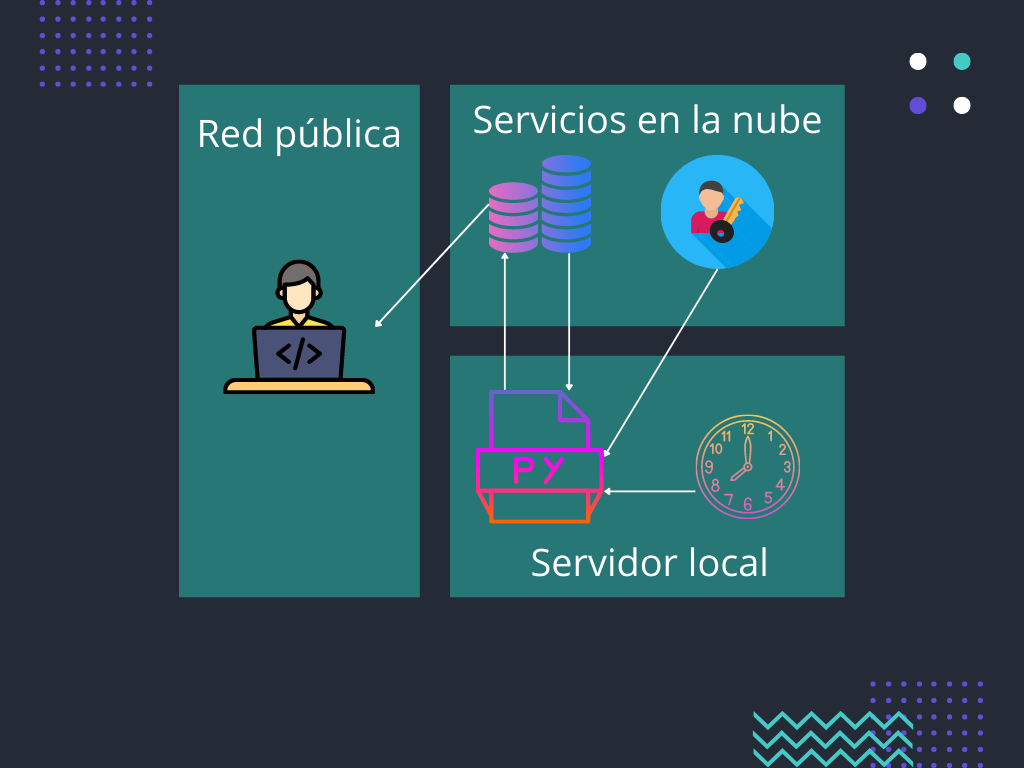

El despliegue de la aplicación se realizará pensando en que la información final será usada por un desarrollador quien este encargado de generar la interfaz usuario-plataforma, donde le deberán presentar las recomendaciones, el sistema para la obtención de estas recomendaciones:
-	Inicia con la ejecución automática del aplicativo en un servidor local programado una vez a la semana, se elige un servidor local debido a que la necesidad de recursos computacionales no es alta y la regularidad de su ejecución no se considera frecuente o de necesidad en cortos periodos de tiempo como por ejemplo las necesidades de información en tiempo real. 
-	El aplicativo requiere de una autorización o accesos que puede brindar un administrador de forma remota.
-	Los datos (información del usuario y de las películas) se obtienen de una base de datos en un servicio de nube adquirido, en este mismo entorno se almacenarán los datos (recomendaciones para cada usuario) obtenidos por la aplicación.
-	El desarrollador extraerá la información necesaria a implementar en la plataforma.
